In [1]:
import os
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
import rasterio.plot
from osgeo import gdal
from rasterio import plot, mask, Affine
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS
from shapely.geometry import box
from rasterio.windows import Window
import matplotlib.pyplot as plt
import rasterstats
import rioxarray
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
def create_vrt(input_dir, output_vrt):
    input_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.tif')]
    
    vrt_options = gdal.BuildVRTOptions(resampleAlg='bilinear', addAlpha=False)
    gdal.BuildVRT(output_vrt, input_files, options=vrt_options)

In [3]:
demdir = ['/home/jovyan/nz-landslides/0-brute-raw-data/dem/2016_tiles',
          '/home/jovyan/nz-landslides/0-brute-raw-data/dem/2017_tiles',
          '/home/jovyan/nz-landslides/0-brute-raw-data/dem/2018_tiles']

vrt_path = ["/home/jovyan/nz-landslides/1-raw-data/dem/2016_combined.vrt",
           "/home/jovyan/nz-landslides/1-raw-data/dem/2017_combined.vrt",
           "/home/jovyan/nz-landslides/1-raw-data/dem/2018_combined.vrt"]

for dir, vrt in zip(demdir, vrt_path):
    create_vrt(dir, vrt)

/srv/conda/envs/notebook/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [4]:
vrt16_fn = vrt_path[0]
vrt16_src = rio.open(vrt16_fn)
vrt16_r = vrt16_src.read(1, masked=True)

vrt17_fn = vrt_path[1]
vrt17_src = rio.open(vrt17_fn)
vrt17_r = vrt17_src.read(1, masked=True)

vrt18_fn = vrt_path[2]
vrt18_src = rio.open(vrt18_fn)
vrt18_r = vrt18_src.read(1, masked=True)

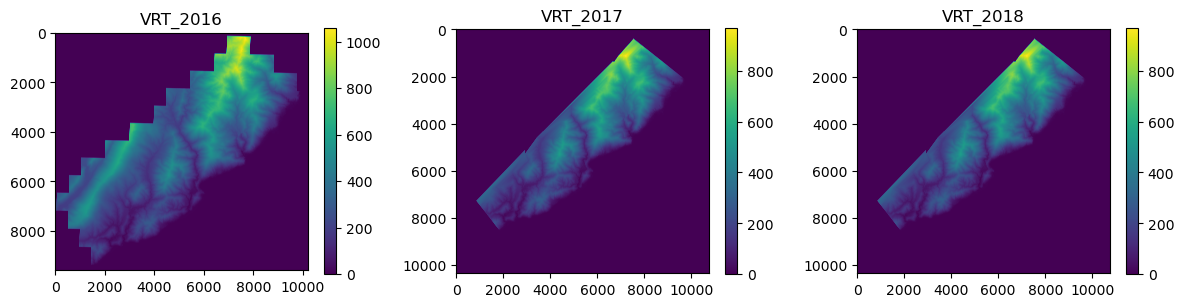

In [5]:
f, ax = plt.subplots(1,3, figsize=(12, 3))
im = ax[0].imshow(vrt16_r)
ax[0].set_title('VRT_2016')
f.colorbar(im, ax=ax[0])
im = ax[1].imshow(vrt17_r)
ax[1].set_title('VRT_2017')
f.colorbar(im, ax=ax[1])
im = ax[2].imshow(vrt18_r)
ax[2].set_title('VRT_2018')
f.colorbar(im, ax=ax[2])
plt.tight_layout()

In [6]:
vrt16_r.shape

(9592, 10215)

In [7]:
vrt17_r.shape

(10365, 10749)

In [8]:
vrt18_r.shape

(10365, 10749)

In [9]:
def resample_vrt(input_path, output_path):
    # Open the input VRT file
    input_dataset = gdal.Open(input_path)

    # Get the projection and geotransform
    projection = input_dataset.GetProjection()
    geotransform = input_dataset.GetGeoTransform()

    # Set the desired pixel size
    pixel_size = 1  # 1 meter pixel size

    # Calculate the output width and height
    width = int(input_dataset.RasterXSize * abs(geotransform[1]) / pixel_size)
    height = int(input_dataset.RasterYSize * abs(geotransform[5]) / pixel_size)

    # Create options for gdal.Warp() to specify the target resolution
    options = gdal.WarpOptions(xRes=pixel_size, yRes=-pixel_size, targetAlignedPixels=True, resampleAlg='bilinear')

    # Perform the resampling
    gdal.Warp(output_path, input_dataset, options=options)

In [10]:
vrt_path = ["/home/jovyan/nz-landslides/1-raw-data/dem/2016_combined.vrt",
           "/home/jovyan/nz-landslides/1-raw-data/dem/2017_combined.vrt",
           "/home/jovyan/nz-landslides/1-raw-data/dem/2018_combined.vrt"]

res_vrt_path = ["/home/jovyan/nz-landslides/1-raw-data/dem/2016_combined_res.vrt",
                "/home/jovyan/nz-landslides/1-raw-data/dem/2017_combined_res.vrt",
                "/home/jovyan/nz-landslides/1-raw-data/dem/2018_combined_res.vrt"]

for input, output in zip(vrt_path, res_vrt_path):
    resample_vrt(input, output)

In [11]:
def generate_hillshade(input_vrt, output_hillshade):
    # Open the input VRT file
    dataset = gdal.Open(input_vrt, gdal.GA_ReadOnly)

    if dataset is None:
        print("Failed to open the input VRT file.")
        return

    # Generate the hillshade
    hillshade = gdal.DEMProcessing(output_hillshade, dataset, "hillshade")

In [12]:
def create_vrt_from_tifs(input_tifs, output_vrt):
    # Create a list of input TIFF files
    input_files = input_tifs

    # Create VRT options
    vrt_options = gdal.BuildVRTOptions(resampleAlg='bilinear', separate=True)

    # Create VRT
    gdal.BuildVRT(output_vrt, input_files, options=vrt_options)

In [13]:
hs_tif_path = ["/home/jovyan/nz-landslides_local/1-raw-data/dem/2016_hs.tif",
                "/home/jovyan/nz-landslides_local/1-raw-data/dem/2017_hs.tif",
                "/home/jovyan/nz-landslides_local/1-raw-data/dem/2018_hs.tif"]

In [14]:
hs_vrt_path = ["/home/jovyan/nz-landslides/1-raw-data/dem/2016_hs.vrt",
                "/home/jovyan/nz-landslides/1-raw-data/dem/2017_hs.vrt",
                "/home/jovyan/nz-landslides/1-raw-data/dem/2018_hs.vrt"]

In [15]:
for dem, tif, vrt in zip(res_vrt_path, hs_tif_path, hs_vrt_path):
    generate_hillshade(dem, tif)
    create_vrt_from_tifs(tif, vrt)